# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to pull together the pieces we've learned to build an [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/) with long-term memory.

Our agent, `task_mAIstro`, will help us manage a ToDo list! 

The chatbots we built previously *always* reflected on the conversation and saved memories. 

`task_mAIstro` will decide *when* to save memories (items to our ToDo list).

The chatbots we built previously always saved one type of memory, a profile or a collection. 

`task_mAIstro` can decide to save to either a user profile or a collection of ToDo items.

In addition semantic memory, `task_mAIstro` also will manage procedural memory.

This allows the user to update their preferences for creating ToDo items. 

In [43]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph trustcall langchain_core

In [75]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [76]:
_set_env("OPENAI_API_KEY")

## Visibility into Trustcall updates

Trustcall creates and updates JSON schemas.

What if we want visibility into the *specific changes* made by Trustcall?

For example, we saw before that Trustcall has some of its own tools to:

* Self-correct from validation failures -- [see trace example here](https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r/9684db76-2003-443b-9aa2-9a9dbc5498b7) 
* Update existing documents -- [see trace example here](https://smith.langchain.com/public/f45bdaf0-6963-4c19-8ec9-f4b7fe0f68ad/r/760f90e1-a5dc-48f1-8c34-79d6a3414ac3)

Visibility into these tools can be useful for the agent we're going to build.

Below, we'll show how to do this!

In [77]:
from pydantic import BaseModel, Field

class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")

class MemoryCollection(BaseModel):
    memories: list[Memory] = Field(description="A list of memories about the user.")

We can add a [listener](https://python.langchain.com/docs/how_to/lcel_cheatsheet/#add-lifecycle-listeners) to the Trustcall extractor.

This will pass runs from the extractor's execution to a class, `Spy`, that we will define.

Our `Spy` class will extract information about what tool calls were made by Trustcall.

In [78]:
from trustcall import create_extractor
from langchain_openai import ChatOpenAI

# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        from pprint import pprint
        print("--------------------------------Spy--------------------------------")
        pprint(run)
        print("--------------------------------Spy--------------------------------")
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,
)

# Add the spy as a listener
trustcall_extractor_see_all_tool_calls = trustcall_extractor.with_listeners(on_end=spy)

In [79]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Instruction
instruction = """Extract memories from the following conversation:"""

# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="This morning I had a nice bike ride in San Francisco.")]

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [80]:
from pprint import pprint
pprint(result)

{'attempts': 1,
 'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YYGqgSxxFAX2SvxKnmYpqVB2', 'function': {'arguments': '{"content":"Lance had a nice bike ride in San Francisco this morning."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 108, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqtkKfkYv7oLfPem0oki9cW3BZUaT', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ab6a8398-98f8-4235-990b-d71a9f83cbce-0', tool_calls=[{'name': 'Memory', 'args': {'content': 'Lance had a nice bike ride in San Francisco this morning.'}, 'id': 'call_YYGqgSxxFAX2SvxKnmYpqVB2', 'type': 't

In [81]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_YYGqgSxxFAX2SvxKnmYpqVB2)
 Call ID: call_YYGqgSxxFAX2SvxKnmYpqVB2
  Args:
    content: Lance had a nice bike ride in San Francisco this morning.


In [82]:
# Responses contain the memories that adhere to the schema
for m in result["responses"]: 
    print(m)

content='Lance had a nice bike ride in San Francisco this morning.'


In [83]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_YYGqgSxxFAX2SvxKnmYpqVB2'}


In [84]:
# Invoke the extractor with seeing all tool calls
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": [SystemMessage(content=instruction)] + conversation})
from pprint import pprint
pprint(result)

--------------------------------Spy--------------------------------
RunTree(id=5d5c386e-e31a-4afd-b470-c38dc73418c1, name='RunnableSequence', run_type='chain', dotted_order='20250708T035732400730Z5d5c386e-e31a-4afd-b470-c38dc73418c1')
--------------------------------Spy--------------------------------
{'attempts': 1,
 'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Gx8Qv3UvkdVwHPenRGaHBYpO', 'function': {'arguments': '{"content":"Lance had a nice bike ride in San Francisco this morning."}', 'name': 'Memory'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 108, 'total_tokens': 125, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BqtkSV24RG1U

In [85]:
# Update the conversation
updated_conversation = [AIMessage(content="That's great, did you do after?"), 
                        HumanMessage(content="I went to Tartine and ate a croissant."),                        
                        AIMessage(content="What else is on your mind?"),
                        HumanMessage(content="I was thinking about my Japan, and going back this winter!"),]

# Update the instruction
system_msg = """Update existing memories and create new ones based on the following conversation:"""

# We'll save existing memories, giving them an ID, key (tool name), and value
tool_name = "Memory"
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None

from pprint import pprint
pprint(existing_memories)

[('0',
  'Memory',
  {'content': 'Lance had a nice bike ride in San Francisco this morning.'})]


In [86]:
# Invoke the extractor with our updated conversation and existing memories
result = trustcall_extractor_see_all_tool_calls.invoke({"messages": updated_conversation, 
                                                        "existing": existing_memories})

from pprint import pprint
pprint(result)

--------------------------------Spy--------------------------------
RunTree(id=615c9d6f-7e11-43c0-a82f-3d6f454e72cf, name='RunnableSequence', run_type='chain', dotted_order='20250708T035737031955Z615c9d6f-7e11-43c0-a82f-3d6f454e72cf')
--------------------------------Spy--------------------------------
{'attempts': 1,
 'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {'call_orrUHY6UNeJeGvzj6mLH5zYk': '0'}}, response_metadata={}, id='27f9d972-b7a2-4396-8a60-1a3f5160e3d5', tool_calls=[{'name': 'Memory', 'args': {'content': 'Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant.'}, 'id': 'call_orrUHY6UNeJeGvzj6mLH5zYk', 'type': 'tool_call'}, {'name': 'Memory', 'args': {'content': 'Lance was thinking about his trip to Japan and considering going back this winter.'}, 'id': 'call_VamYIPWnV20k6M6NQxeqwhod', 'type': 'tool_call'}])],
 'response_metadata': [{'id': 'call_orrUHY6UNeJeGvzj6mLH5zYk',
                        'j

In [87]:
# Metadata contains the tool call  
for m in result["response_metadata"]: 
    print(m)

{'id': 'call_orrUHY6UNeJeGvzj6mLH5zYk', 'json_doc_id': '0'}
{'id': 'call_VamYIPWnV20k6M6NQxeqwhod'}


In [88]:
# Messages contain the tool calls
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_orrUHY6UNeJeGvzj6mLH5zYk)
 Call ID: call_orrUHY6UNeJeGvzj6mLH5zYk
  Args:
    content: Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant.
  Memory (call_VamYIPWnV20k6M6NQxeqwhod)
 Call ID: call_VamYIPWnV20k6M6NQxeqwhod
  Args:
    content: Lance was thinking about his trip to Japan and considering going back this winter.


In [89]:
# Parsed responses
for m in result["responses"]:
    print(m)

content='Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant.'
content='Lance was thinking about his trip to Japan and considering going back this winter.'


In [90]:
# Inspect the tool calls made by Trustcall
spy.called_tools

[[{'name': 'Memory',
   'args': {'content': 'Lance had a nice bike ride in San Francisco this morning.'},
   'id': 'call_Gx8Qv3UvkdVwHPenRGaHBYpO',
   'type': 'tool_call'}],
 [{'name': 'PatchDoc',
   'args': {'json_doc_id': '0',
    'planned_edits': 'Add a new memory entry about going to Tartine and eating a croissant after the bike ride in San Francisco. This involves appending a new sentence to the existing content field in the Memory schema.',
    'patches': [{'op': 'replace',
      'path': '/content',
      'value': 'Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant.'}]},
   'id': 'call_orrUHY6UNeJeGvzj6mLH5zYk',
   'type': 'tool_call'},
  {'name': 'Memory',
   'args': {'content': 'Lance was thinking about his trip to Japan and considering going back this winter.'},
   'id': 'call_VamYIPWnV20k6M6NQxeqwhod',
   'type': 'tool_call'}]]

### spy.called_tools
```python
[
  [
    {
      name: "PatchDoc",
      args: {
        json_doc_id: "0",
        planned_edits:
          "Add the new memory of going to Tartine and eating a croissant after the bike ride. Also, add the memory of thinking about going back to Japan this winter.",
        patches: [
          {
            op: "replace",
            path: "/content",
            value:
              "Lance had a nice bike ride in San Francisco this morning. After the ride, he went to Tartine and ate a croissant. He was also thinking about his trip to Japan and going back this winter.",
          },
        ],
      },
      id: "call_HlqiWNUXCKwJiDzwgM2h13Mr",
      type: "tool_call",
    },
    {
      name: "Memory",
      args: {
        content:
          "Lance went to Tartine and ate a croissant after his bike ride in San Francisco. He was also thinking about his trip to Japan and going back this winter.",
      },
      id: "call_7kq11E69u3JvEMxdGHULIFhx",
      type: "tool_call",
    },
  ],
]
```

In [91]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    # This function, extract_tool_info, processes a list of tool calls (such as those made by an LLM agent)
    # and extracts structured information about document updates (via PatchDoc) and new memory creations (via Memory or another schema).
    # It returns a formatted string summarizing the changes, including both updates to existing documents and creation of new memory entries.
    #
    # PatchDoc is a tool call schema used to represent an update (or "patch") to an existing document.
    # When the agent wants to modify a document (such as adding new information or editing content),
    # it issues a PatchDoc tool call. This call typically includes:
    #   - 'json_doc_id': the identifier of the document to be updated,
    #   - 'planned_edits': a description of the intended changes,
    #   - 'patches': a list of patch operations (e.g., add, replace) specifying exactly what to change and where.
    # PatchDoc enables the agent to make structured, auditable changes to persistent documents.
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc': # If the tool call is a PatchDoc, add the update to the changes list
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
schema_name = "Memory"
changes = extract_tool_info(spy.called_tools, schema_name)
print(changes)

New Memory created:
Content: {'content': 'Lance had a nice bike ride in San Francisco this morning.'}

Document 0 updated:
Plan: Add a new memory entry about going to Tartine and eating a croissant after the bike ride in San Francisco. This involves appending a new sentence to the existing content field in the Memory schema.
Added content: Lance had a nice bike ride in San Francisco this morning. Afterward, he went to Tartine and ate a croissant.

New Memory created:
Content: {'content': 'Lance was thinking about his trip to Japan and considering going back this winter.'}


## Creating an agent

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple, a [ReAct](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

This agent will be a helpful companion for creating and managing a ToDo list.

This agent can make a decision to update three types of long-term memory: 

(a) Create or update a user `profile` with general user information 

(b) Add or update items in a ToDo list `collection`

(c) Update its own `instructions` on how to update items to the ToDo list

In [92]:
from typing import TypedDict, Literal

# Update memory tool
class UpdateMemory(TypedDict):
    """ Decision on what memory type to update """
    update_type: Literal['user', 'todo', 'instructions']

In [93]:
_set_env("OPENAI_API_KEY")

## Logging Tool for debugging

We can use the following code to safely serialize the messages for JSON printing.


In [107]:
# Global flag to enable/disable logging
DEBUG_MESSAGES = True

# Safely serialize updated_messages for JSON printing
def safe_serialize_message(msg):
    # Handle common LangChain message types
    try:
        from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, BaseMessage
    except ImportError:
        AIMessage = HumanMessage = SystemMessage = BaseMessage = None

    # Handle Pydantic v2 and v1 models
    if hasattr(msg, "model_dump"):
        return msg.model_dump()
    elif hasattr(msg, "dict"):
        return msg.dict()
    # Handle list of messages recursively
    elif isinstance(msg, list):
        return [safe_serialize_message(m) for m in msg]
    # Handle dicts, but recursively serialize values
    elif isinstance(msg, dict):
        return {k: safe_serialize_message(v) for k, v in msg.items()}
    # Handle common error types
    elif isinstance(msg, Exception):
        return {"error_type": type(msg).__name__, "error_message": str(msg)}
    # Handle objects with __dict__ attribute
    elif hasattr(msg, "__dict__"):
        return {k: safe_serialize_message(v) for k, v in msg.__dict__.items()}
    # Handle LangChain message objects
    if AIMessage and isinstance(msg, AIMessage):
        return {"type": "AIMessage", "content": msg.content}
    elif HumanMessage and isinstance(msg, HumanMessage):
        return {"type": "HumanMessage", "content": msg.content}
    elif SystemMessage and isinstance(msg, SystemMessage):
        return {"type": "SystemMessage", "content": msg.content}
    elif BaseMessage and isinstance(msg, BaseMessage):
        # fallback for other message types
        return {"type": msg.__class__.__name__, "content": getattr(msg, "content", str(msg))}
    # Fallback to string
    return str(msg)

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

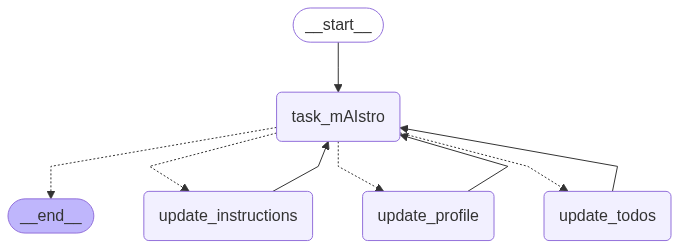

In [95]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore

from langchain_openai import ChatOpenAI

from pprint import pprint
import json

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# User profile schema
class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list # default_factory=list means that the list is empty by default
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list # default_factory=list means that the list is empty by default
    )

# ToDo schema
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )

# Create the Trustcall extractor for updating the user profile 
profile_extractor = create_extractor(
    model,
    tools=[Profile],
    tool_choice="Profile",
)

# Chatbot instruction for choosing what to update and what tools to call 
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

# Trustcall instruction
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""

# Instructions for updating the ToDo list
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""

# Node definitions
def task_mAIstro(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve profile memory from the store
    namespace = ("profile", user_id)
    memories = store.search(namespace)
    if memories:
        user_profile = memories[0].value
    else:
        user_profile = None

    # Retrieve task memory from the store
    namespace = ("todo", user_id)
    memories = store.search(namespace)
    todo = "\n".join(f"{mem.value}" for mem in memories)

    # Retrieve custom instructions
    namespace = ("instructions", user_id)
    memories = store.search(namespace)
    if memories:
        instructions = memories[0].value
    else:
        instructions = ""
    
    system_msg = MODEL_SYSTEM_MESSAGE.format(user_profile=user_profile, todo=todo, instructions=instructions)

    print('\n\n---- task_mAIstro() ----\n\n', json.dumps({
        "system_msg": system_msg,
        "state['messages']": [msg.model_dump() if hasattr(msg, "model_dump") else msg for msg in state["messages"]]
    }, indent=2, ensure_ascii=False)) if DEBUG_MESSAGES else None

    # Respond using memory as well as the chat history
    response = model.bind_tools([UpdateMemory], parallel_tool_calls=False).invoke([SystemMessage(content=system_msg)]+state["messages"])

    print('\n\n---- task_mAIstro() response ----\n\n', json.dumps({
        "response": safe_serialize_message(response)
    }, indent=2, ensure_ascii=False), '\n\n') if DEBUG_MESSAGES else None

    return {"messages": [response]}

def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    print('\n\n---- update_profile() profile_extractor.invoke() ----\n\n', json.dumps({
        "state['messages']": safe_serialize_message(state["messages"]),
        "messages": safe_serialize_message(updated_messages),
        "existing": safe_serialize_message(existing_memories)
    }, indent=2, ensure_ascii=False)) if DEBUG_MESSAGES else None

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    print('\n\n---- update_profile() profile_extractor.invoke() result ----\n\n', json.dumps({
        "result": safe_serialize_message(result)
    }, indent=2, ensure_ascii=False), '\n\n') if DEBUG_MESSAGES else None

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls

    # This line returns a dictionary with a single key "messages", whose value is a list containing one message dictionary.
    # The message has:
    #   - "role": "tool" (indicating this message is from a tool, not a user or assistant)
    #   - "content": "updated profile" (the content of the message)
    #   - "tool_call_id": tool_calls[0]['id'] (associates this message with the first tool call's ID from the most recent user message)
    # This structure is typically used in LangChain and OpenAI function-calling APIs to return tool outputs in a standardized way.
    # The rule is: when responding to a tool call, you must return a message with "role": "tool", the corresponding "tool_call_id", and the output in "content".
    return {
        "messages": [
            {
                "role": "tool",
                "content": "updated profile",
                "tool_call_id": tool_calls[0]['id']
            }
        ]
    }

def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    model,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    print('\n\n---- update_todos() todo_extractor.invoke() ----\n\n', json.dumps({
        "messages": safe_serialize_message(updated_messages),
        "existing": safe_serialize_message(existing_memories)
    }, indent=2, ensure_ascii=False)) if DEBUG_MESSAGES else None

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    print('\n\n---- update_todos() todo_extractor.invoke() result ----\n\n', json.dumps({
        "result": safe_serialize_message(result)
    }, indent=2, ensure_ascii=False), '\n\n') if DEBUG_MESSAGES else None

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)

    # This line returns a dictionary with a single key "messages", whose value is a list containing one message dictionary.
    # The message has:
    #   - "role": "tool" (indicating this message is from a tool, not a user or assistant)
    #   - "content": todo_update_msg (the content of the message)
    #   - "tool_call_id": tool_calls[0]['id'] (associates this message with the first tool call's ID from the most recent user message)
    # This structure is typically used in LangChain and OpenAI function-calling APIs to return tool outputs in a standardized way.
    # The rule is: when responding to a tool call, you must return a message with "role": "tool", the corresponding "tool_call_id", and the output in "content".
    return {
        "messages": [
            {
                "role": "tool",
                "content": todo_update_msg,
                "tool_call_id": tool_calls[0]['id']
            }
        ]
    }    

def update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")

    print('\n\n---- update_instructions() model.invoke() existing_memory ----\n\n', json.dumps({
        "existing_memory": safe_serialize_message(existing_memory)
    }, indent=2, ensure_ascii=False)) if DEBUG_MESSAGES else None

    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    print('\n\n---- update_instructions() model.invoke() new_memory ----\n\n', json.dumps({
        "new_memory": safe_serialize_message(new_memory)
    }, indent=2, ensure_ascii=False), '\n\n') if DEBUG_MESSAGES else None

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls

    # This line returns a dictionary with a single key "messages", whose value is a list containing one message dictionary.
    # The message has:
    #   - "role": "tool" (indicating this message is from a tool, not a user or assistant)
    #   - "content": "updated instructions" (the content of the message)
    #   - "tool_call_id": tool_calls[0]['id'] (associates this message with the first tool call's ID from the most recent user message)
    # This structure is typically used in LangChain and OpenAI function-calling APIs to return tool outputs in a standardized way.
    # The rule is: when responding to a tool call, you must return a message with "role": "tool", the corresponding "tool_call_id", and the output in "content".
    return {
        "messages": [
            {
                "role": "tool",
                "content": "updated instructions",
                "tool_call_id": tool_calls[0]['id']
            }
        ]
    }

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "update_instructions", "update_profile"]:

    """Reflect on the memories and chat history to decide whether to update the memory collection."""
    message = state['messages'][-1]
    if len(message.tool_calls) ==0: 
        return END
    else:
        tool_call = message.tool_calls[0]
        if tool_call['args']['update_type'] == "user":
            return "update_profile"
        elif tool_call['args']['update_type'] == "todo":
            return "update_todos"
        elif tool_call['args']['update_type'] == "instructions":
            return "update_instructions"
        else:
            raise ValueError

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("update_instructions", "task_mAIstro")

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [108]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "Lance"}}

# User input to create a profile memory
input_messages = [HumanMessage(content="My name is Lance. I live in SF with my wife. I have a 1 year old daughter.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My name is Lance. I live in SF with my wife. I have a 1 year old daughter.


---- task_mAIstro() ----

 {
  "system_msg": "You are a helpful chatbot. \n\nYou are designed to be a companion to a user, helping them keep track of their ToDo list.\n\nYou have a long term memory which keeps track of three things:\n1. The user's profile (general information about them) \n2. The user's ToDo list\n3. General instructions for updating the ToDo list\n\nHere is the current User Profile (may be empty if no information has been collected yet):\n<user_profile>\n{'name': 'Lance', 'location': 'SF', 'job': None, 'connections': ['wife', '1 year old daughter'], 'interests': []}\n</user_profile>\n\nHere is the current ToDo List (may be empty if no tasks have been added yet):\n<todo>\n{'task': 'Book swim lessons for the baby', 'time_to_complete': 30, 'deadline': '2025-11-30T23:59:59', 'solutions': ['La Petite Baleen Swim Scho

In [97]:
# User input for a ToDo
input_messages = [HumanMessage(content="My wife asked me to book swim lessons for the baby.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My wife asked me to book swim lessons for the baby.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_MvRXy2T2g3xSvJHBd30UUhaK)
 Call ID: call_MvRXy2T2g3xSvJHBd30UUhaK
  Args:
    update_type: todo
--------------------------------Spy--------------------------------
RunTree(id=a53666c0-d40e-4597-8c74-69c587a719bb, name='RunnableSequence', run_type='chain', dotted_order='20250708T035852489282Za53666c0-d40e-4597-8c74-69c587a719bb')
--------------------------------Spy--------------------------------
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Book swim lessons for the baby', 'time_to_complete': 30, 'solutions': ['Local swim schools', 'Community centers with baby swim classes', 'Online booking platforms for baby activities'], 'status': 'not started'}
=======================

In [98]:
# User input to update instructions for creating ToDos
input_messages = [HumanMessage(content="When creating or updating ToDo items, include specific local businesses / vendors.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

When creating or updating ToDo items, include specific local businesses / vendors.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_mHzbfYqSu0LF07GrixfF6O6F)
 Call ID: call_mHzbfYqSu0LF07GrixfF6O6F
  Args:
    update_type: instructions
================================= Tool Message =================================

updated instructions
================================== Ai Message ==================================

Got it! I'll make sure to include specific local businesses or vendors when creating or updating your ToDo items. If you have any other preferences, just let me know!


In [99]:
# Check for updated instructions
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("instructions", user_id)):
    pprint(memory.value)

{'memory': '<current_instructions>\n'
           'When creating or updating ToDo items, include specific local '
           'businesses or vendors relevant to the task. For example, if the '
           'task is to book swim lessons, suggest local swim schools or '
           "community centers in the user's area.\n"
           '</current_instructions>'}


In [100]:
# User input for a ToDo
input_messages = [HumanMessage(content="I need to fix the jammed electric Yale lock on the door.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to fix the jammed electric Yale lock on the door.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_V7x8GLUkNDU9waGzYsrKLJyX)
 Call ID: call_V7x8GLUkNDU9waGzYsrKLJyX
  Args:
    update_type: todo
--------------------------------Spy--------------------------------
RunTree(id=006afbc2-59a9-49b8-bb0a-4c9c107c74d9, name='RunnableSequence', run_type='chain', dotted_order='20250708T035910166751Z006afbc2-59a9-49b8-bb0a-4c9c107c74d9')
--------------------------------Spy--------------------------------
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Fix the jammed electric Yale lock on the door', 'time_to_complete': 60, 'solutions': ['Contact Yale customer support', 'Hire a local locksmith specializing in electronic locks', 'Check online tutorials for troubleshooting Yale lo

In [101]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    pprint(memory.value)

{'deadline': None,
 'solutions': ['La Petite Baleen Swim School',
               'AquaTech Swim School',
               'SF Recreation and Parks Department baby swim classes'],
 'status': 'not started',
 'task': 'Book swim lessons for the baby',
 'time_to_complete': 30}
{'deadline': None,
 'solutions': ['Contact Yale customer support',
               'Hire a local locksmith specializing in electronic locks',
               'Check online tutorials for troubleshooting Yale locks'],
 'status': 'not started',
 'task': 'Fix the jammed electric Yale lock on the door',
 'time_to_complete': 60}


In [102]:
# User input to update an existing ToDo
input_messages = [HumanMessage(content="For the swim lessons, I need to get that done by end of November.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

For the swim lessons, I need to get that done by end of November.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_fFqlP4dApyDm6DBk27qASvqk)
 Call ID: call_fFqlP4dApyDm6DBk27qASvqk
  Args:
    update_type: todo
--------------------------------Spy--------------------------------
RunTree(id=7262f7ac-c7e0-4679-83fc-8be5d1c481e7, name='RunnableSequence', run_type='chain', dotted_order='20250708T035923823613Z7262f7ac-c7e0-4679-83fc-8be5d1c481e7')
--------------------------------Spy--------------------------------
================================= Tool Message =================================

Document b038d406-f57e-432f-8e00-d5541405d45d updated:
Plan: Add a deadline to the task to ensure it is completed by the end of November. This involves setting the 'deadline' field to '2025-11-30T23:59:59'.
Added content: 2025-11-30T23:59:59
===============

We can see that Trustcall performs patching of the existing memory:

https://smith.langchain.com/public/4ad3a8af-3b1e-493d-b163-3111aa3d575a/r

In [103]:
# User input for a ToDo
input_messages = [HumanMessage(content="Need to call back City Toyota to schedule car service.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Need to call back City Toyota to schedule car service.
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_J8d12x1kn6kywVsxy8rFtf0A)
 Call ID: call_J8d12x1kn6kywVsxy8rFtf0A
  Args:
    update_type: todo
--------------------------------Spy--------------------------------
RunTree(id=f5a55589-0be1-441b-b422-9be8c338e60f, name='RunnableSequence', run_type='chain', dotted_order='20250708T035934457725Zf5a55589-0be1-441b-b422-9be8c338e60f')
--------------------------------Spy--------------------------------
================================= Tool Message =================================

New ToDo created:
Content: {'task': 'Call back City Toyota to schedule car service', 'time_to_complete': 15, 'solutions': ['Find the contact number for City Toyota', 'Check available service slots', 'Prepare any necessary car details for the call'], 'status': 'not sta

In [104]:
# Namespace for the memory to save
user_id = "Lance"

# Search 
for memory in across_thread_memory.search(("todo", user_id)):
    pprint(memory.value)

{'deadline': '2025-11-30T23:59:59',
 'solutions': ['La Petite Baleen Swim School',
               'AquaTech Swim School',
               'SF Recreation and Parks Department baby swim classes'],
 'status': 'not started',
 'task': 'Book swim lessons for the baby',
 'time_to_complete': 30}
{'deadline': None,
 'solutions': ['Contact Yale customer support',
               'Hire a local locksmith specializing in electronic locks',
               'Check online tutorials for troubleshooting Yale locks'],
 'status': 'not started',
 'task': 'Fix the jammed electric Yale lock on the door',
 'time_to_complete': 60}
{'deadline': None,
 'solutions': ['Find the contact number for City Toyota',
               'Check available service slots',
               'Prepare any necessary car details for the call'],
 'status': 'not started',
 'task': 'Call back City Toyota to schedule car service',
 'time_to_complete': 15}


Now we can create a new thread.

This creates a new session. 

Profile, ToDos, and Instructions saved to long-term memory are accessed. 

In [105]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "Lance"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="I have 30 minutes, what tasks can I get done?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have 30 minutes, what tasks can I get done?
================================== Ai Message ==================================

You can complete the following tasks in 30 minutes or less:

1. **Book swim lessons for the baby** - This task is estimated to take 30 minutes.
2. **Call back City Toyota to schedule car service** - This task is estimated to take 15 minutes.

You can choose either of these tasks to work on within your available time. Let me know if you need any assistance with them!


In [106]:
# Chat with the chatbot
input_messages = [HumanMessage(content="Yes, give me some options to call for swim lessons.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, give me some options to call for swim lessons.
================================== Ai Message ==================================

Here are some options for booking swim lessons for your baby:

1. **La Petite Baleen Swim School** - They offer a variety of swim classes for babies and young children.
2. **AquaTech Swim School** - Known for their baby swim programs and experienced instructors.
3. **SF Recreation and Parks Department baby swim classes** - They provide community-based swim classes for babies.

You can contact any of these places to inquire about their schedules and book a class that suits your needs. Let me know if you need more information!


Trace: 

https://smith.langchain.com/public/84768705-be91-43e4-8a6f-f9d3cee93782/r

## Studio

![Screenshot 2024-11-04 at 1.00.19 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732cfb05d9709862eba4e6c_Screenshot%202024-11-11%20at%207.46.40%E2%80%AFPM.png)